In [1]:
from binance.client import Client
import os, re, joblib, time, gc
import shap
import pandas as pd
import numpy as np
import datetime as dt
from talib.abstract import *
from filehandling import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

@save_decorator_zip
def dfpickle(df, path):
    df.to_pickle(path, compression='gzip')

@load_decorator_zip
def dfunpickle(path):
    df = pd.read_pickle(path, compression='gzip')
    return df

def linregress_trend(series):
    slope, intercept, r_value, p_value, std_err = linregress(np.arange(series.shape[0]), series)
    return slope * r_value**2

def create_dataframe(symbol, interval, download_requested=False, start='2000-01-01', end=None):
    if download_requested:
        client = Client('', '')
        klines = client.get_historical_klines(symbol, interval, start, end)

        opening_times = list()
        closing_times = list()
        for tick in klines:
            opening_times.append(dt.datetime.fromtimestamp(tick[0] / 1000.0 - 3600.0))
            closing_times.append(dt.datetime.fromtimestamp(tick[6] / 1000.0 - 3600.0))

        df = pd.DataFrame(klines, dtype=float, index=opening_times, columns=[0, 'open', 'high', 'low', 'close', 'volume', 6, 'quote_asset_vol', 'no_of_trades', 'taker_buy_base_vol', 'taker_buy_quote_vol', 11])
        df['close_time'] = closing_times
        del df[0], df[6], df[11], klines, opening_times, closing_times
        
        df.index = df.index.tz_localize('CET', ambiguous='infer').shift(1, freq='1h')
        df.index = df.index.tz_convert(None)
        df.drop(df.index[-1], inplace=True)
        dfpickle(df, path)
    else:
        df = dfunpickle(path)
        df = df.loc[start:end]
    
    df['rsi'] = RSI(df, timeperiod=14)
    df['rsi_trend'] = df['rsi'].rolling(10).apply(linregress_trend)
    df['ema10'] = EMA(df, timeperiod=10)
    df['ema20'] = EMA(df, timeperiod=21)
    df['sma50'] = SMA(df, timeperiod=50)
    df['sma100'] = SMA(df, timeperiod=100)
    df['sma200'] = SMA(df, timeperiod=200)
    df['sma500'] = SMA(df, timeperiod=500)
    df['sma1000'] = SMA(df, timeperiod=1000)
    df['std20'] = STDDEV(df, timeperiod=20)
    df['atr10'] = ATR(df, timeperiod=10)
    df['atr100'] = ATR(df, timeperiod=100)
    df['keltner_upper'] = df['ema20'] + 2 * df['atr10']
    df['keltner_lower'] = df['ema20'] - 2 * df['atr10']
    stoch = STOCH(df, slowd_period=5)
    df['stoch_slowk'] = stoch.slowk
    df['stoch_slowd'] = stoch.slowd
    stochrsi = STOCHRSI(df, timeperiod=14)
    df['stochrsi_fastk'] = stochrsi.fastk
    df['stochrsi_fastd'] = stochrsi.fastd
    
    return df

download = False
symbol = 'BTCUSDT'
interval = Client.KLINE_INTERVAL_1HOUR
start_time = '2000-01-01'
path = '../data/binance/{}_{}.pkl.gz'.format(symbol, interval)

df = create_dataframe(symbol, interval, download_requested=download, start=start_time)

df.head()

loading data from ../data/binance/BTCUSDT_1h.pkl.gz... ✅


,open,high,low,close,volume,quote_asset_vol,no_of_trades,taker_buy_base_vol,taker_buy_quote_vol,close_time,rsi,rsi_trend,ema10,ema20,sma50,sma100,sma200,sma500,sma1000,std20,atr10,atr100,keltner_upper,keltner_lower,stoch_slowk,stoch_slowd,stochrsi_fastk,stochrsi_fastd
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,202366.138393,171.0,35.160503,150952.477943,2017-08-17 05:59:59.999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,100304.823567,102.0,21.448071,92608.279728,2017-08-17 06:59:59.999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,31282.312670,36.0,4.802861,20795.317224,2017-08-17 07:59:59.999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,19241.058300,25.0,2.602292,11291.347015,2017-08-17 08:59:59.999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,4239.503586,28.0,0.814655,3552.746817,2017-08-17 09:59:59.999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
import xgboost as xgb
from xgboost import XGBRegressor
from utils import gridsearch_xgb, print_top_n, plot_scores_1d, plot_scores_2d

ignored_columns = [
    'quote_asset_vol',
    'no_of_trades',
    'taker_buy_quote_vol',
    'close_time'
]
dfml = df.loc[:, [col not in ignored_columns for col in df.columns]].copy()

forecast_window = 10
label_col = 'lookahead_ma{:d}'.format(forecast_window)

label_cutoff_value = 10.0

# dfml[label_col] = (dfml['close'].shift(-forecast_window) / dfml['close'] - 1.) * 100.
dfml[label_col] = (dfml['close'][::-1].rolling(forecast_window).mean()[::-1] / dfml['close'] - 1.) * 100.

dfml['open'] = dfml['open'] / dfml['close'] - 1.
dfml['high'] = dfml['high'] / dfml['close'] - 1.
dfml['low'] = dfml['low'] / dfml['close'] - 1.
dfml['ema10'] = dfml['ema10'] / dfml['close'] - 1.
dfml['ema20'] = dfml['ema20'] / dfml['close'] - 1.
dfml['sma50'] = dfml['sma50'] / dfml['close'] - 1.
dfml['sma100'] = dfml['sma100'] / dfml['close'] - 1.
dfml['sma200'] = dfml['sma200'] / dfml['close'] - 1.
dfml['sma500'] = dfml['sma500'] / dfml['close'] - 1.
dfml['sma1000'] = dfml['sma1000'] / dfml['close'] - 1.
dfml['std20'] = dfml['std20'] / dfml['close']
dfml['atr10'] = dfml['atr10'] / dfml['close']
dfml['atr100'] = dfml['atr100'] / dfml['close']
dfml['keltner_upper'] = dfml['keltner_upper'] / dfml['close'] - 1.
dfml['keltner_lower'] = dfml['keltner_lower'] / dfml['close'] - 1.

dfml.drop('close', axis=1, inplace=True)

standardised_cols = [
    'volume',
    'taker_buy_base_vol'
]

# mean_dict = {col: dfml.loc[:, col].mean() for col in standardised_cols}
# std_dict = {col: dfml.loc[:, col].std() for col in standardised_cols}

mean_dict = {'volume': 1883.2653201563026, 'taker_buy_base_vol': 943.0650478388751}
std_dict = {'volume': 2056.6755264848543, 'taker_buy_base_vol': 1011.2795091423222}

for col in standardised_cols:
    dfml[col] = (dfml[col] - mean_dict[col]) / std_dict[col]

# dfml_train = dfml.loc[~dfml.isna().any(1) & (dfml[label_col] > -label_cutoff_value) & (dfml[label_col] < label_cutoff_value)]
dfml_train = dfml.loc[~dfml.isna().any(1)]
X = dfml_train.loc[:, dfml.columns != label_col]
y = dfml_train.loc[:, label_col]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

xgb_base_params = {'n_jobs': 4, 'tree_method': 'gpu_hist', 'sampling_method': 'gradient_based'}

dfml.tail()

,open,high,low,volume,taker_buy_base_vol,rsi,rsi_trend,ema10,ema20,sma50,sma100,sma200,sma500,sma1000,std20,atr10,atr100,keltner_upper,keltner_lower,stoch_slowk,stoch_slowd,stochrsi_fastk,stochrsi_fastd,lookahead_ma10
2022-02-03 11:00:00,-0.011042,0.000311,-0.013386,-0.054352,0.088080,39.757281,0.029089,0.001562,0.009057,0.030423,0.029536,0.021151,0.059492,0.156423,0.008362,0.008915,0.010400,0.026886,-0.008772,27.184074,53.442190,99.362500,33.120833,NaN
2022-02-03 12:00:00,0.002480,0.002670,-0.012100,0.006739,0.000776,38.232104,0.048794,0.003310,0.010509,0.032129,0.031733,0.023534,0.061762,0.158903,0.008359,0.009520,0.010469,0.029549,-0.008531,43.059160,48.047958,86.663344,62.008615,NaN
2022-02-03 13:00:00,0.002889,0.005180,-0.003665,-0.253107,-0.273948,36.430658,0.006713,0.005152,0.012289,0.034196,0.034448,0.026443,0.064583,0.161964,0.008148,0.009478,0.010483,0.031245,-0.006667,51.368717,43.254132,72.123656,86.049833,NaN
2022-02-03 14:00:00,0.002174,0.007847,-0.000595,-0.090713,-0.016748,35.131612,0.000031,0.006003,0.013172,0.035270,0.036237,0.028567,0.066557,0.164100,0.007825,0.009393,0.010486,0.031958,-0.005614,46.166725,40.902339,61.237943,73.341648,NaN
2022-02-03 15:00:00,-0.010955,0.001811,-0.011789,0.015613,0.081842,45.745375,0.077192,-0.004105,0.001885,0.022865,0.024561,0.017241,0.054560,0.150970,0.006533,0.009721,0.010403,0.021327,-0.017557,59.163587,45.388453,100.000000,77.787200,NaN


In [13]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(grid7.best_estimator_)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


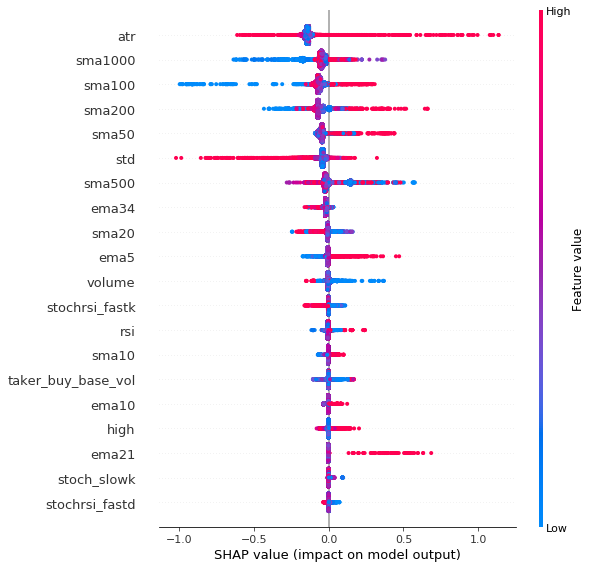

In [15]:
shap.summary_plot(shap_values, X)

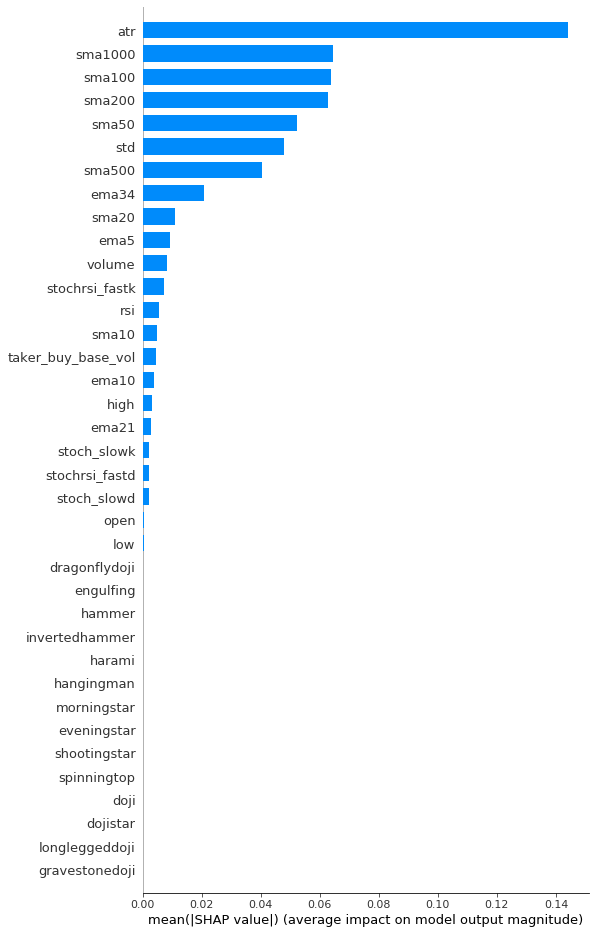

In [17]:
shap.summary_plot(shap_values, X, plot_type="bar", max_display=500)

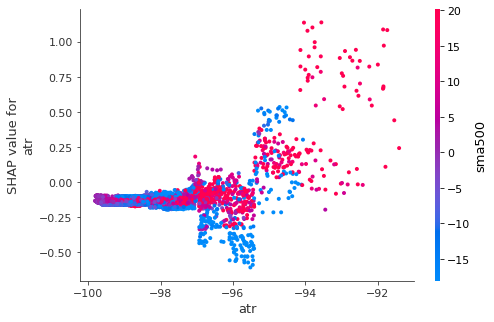

In [30]:
shap.dependence_plot('atr', shap_values, X, interaction_index='auto')

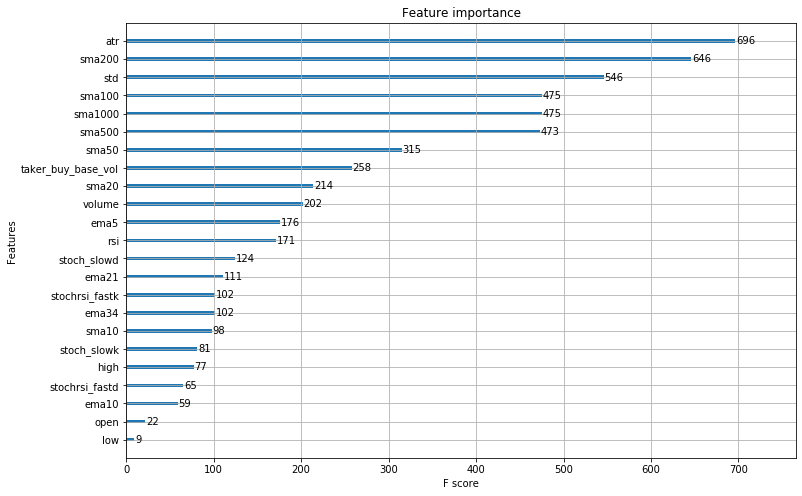

In [16]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
xgb.plot_importance(grid7.best_estimator_, ax=ax)

Grid search with these parameters will take 440 fits, or approximately 43 minutes. Is that ok? (y/N) y
Fitting 5 folds for each of 88 candidates, totalling 440 fits



[Parallel(n_jobs=1)]: Done 440 out of 440 | elapsed: 63.3min finished


true elapsed time: 63.3min

best RMSE: -1.3974451157280925
{'colsample_bynode': 0.8, 'colsample_bytree': 0.5, 'gamma': 4.5, 'learning_rate': 0.0044, 'max_depth': 3, 'min_child_weight': 25, 'n_estimators': 680, 'reg_lambda': 1.35, 'subsample': 0.131}

best R2: -0.0010411669318433736
{'colsample_bynode': 0.8, 'colsample_bytree': 0.5, 'gamma': 4.5, 'learning_rate': 0.0044, 'max_depth': 3, 'min_child_weight': 25, 'n_estimators': 680, 'reg_lambda': 1.35, 'subsample': 0.131}

best MAD: -0.5893319527340216
{'colsample_bynode': 0.8, 'colsample_bytree': 0.5, 'gamma': 4.5, 'learning_rate': 0.0044, 'max_depth': 3, 'min_child_weight': 25, 'n_estimators': 680, 'reg_lambda': 1.35, 'subsample': 0.131}


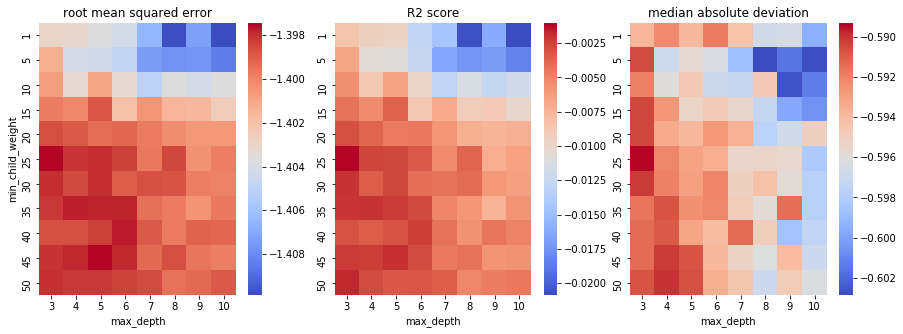

In [3]:
param_grid1 = {
    'learning_rate': [.0044],
    'n_estimators': [680],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'subsample': [.131],
    'colsample_bytree': [0.5],
    'colsample_bynode': [0.8],
    'min_child_weight': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    'gamma': [4.5],
    'reg_lambda': [1.35]
}

grid1 = gridsearch_xgb(X, y, param_grid1, xgb_base_params, save_path='grid1.pkl')
_ = plot_scores_2d(grid1)

Grid search with these parameters will take 505 fits, or approximately 49 minutes. Is that ok? (y/N) y
Fitting 5 folds for each of 101 candidates, totalling 505 fits



[Parallel(n_jobs=1)]: Done 505 out of 505 | elapsed: 38.4min finished


true elapsed time: 38.4min

best RMSE: -1.3971961189680786
{'colsample_bynode': 0.8, 'colsample_bytree': 0.5, 'gamma': 7.4, 'learning_rate': 0.0044, 'max_depth': 3, 'min_child_weight': 25, 'n_estimators': 680, 'reg_lambda': 1.35, 'subsample': 0.131}

best R2: -0.0007327458712069968
{'colsample_bynode': 0.8, 'colsample_bytree': 0.5, 'gamma': 7.4, 'learning_rate': 0.0044, 'max_depth': 3, 'min_child_weight': 25, 'n_estimators': 680, 'reg_lambda': 1.35, 'subsample': 0.131}

best MAD: -0.5874684415812421
{'colsample_bynode': 0.8, 'colsample_bytree': 0.5, 'gamma': 6.7, 'learning_rate': 0.0044, 'max_depth': 3, 'min_child_weight': 25, 'n_estimators': 680, 'reg_lambda': 1.35, 'subsample': 0.131}


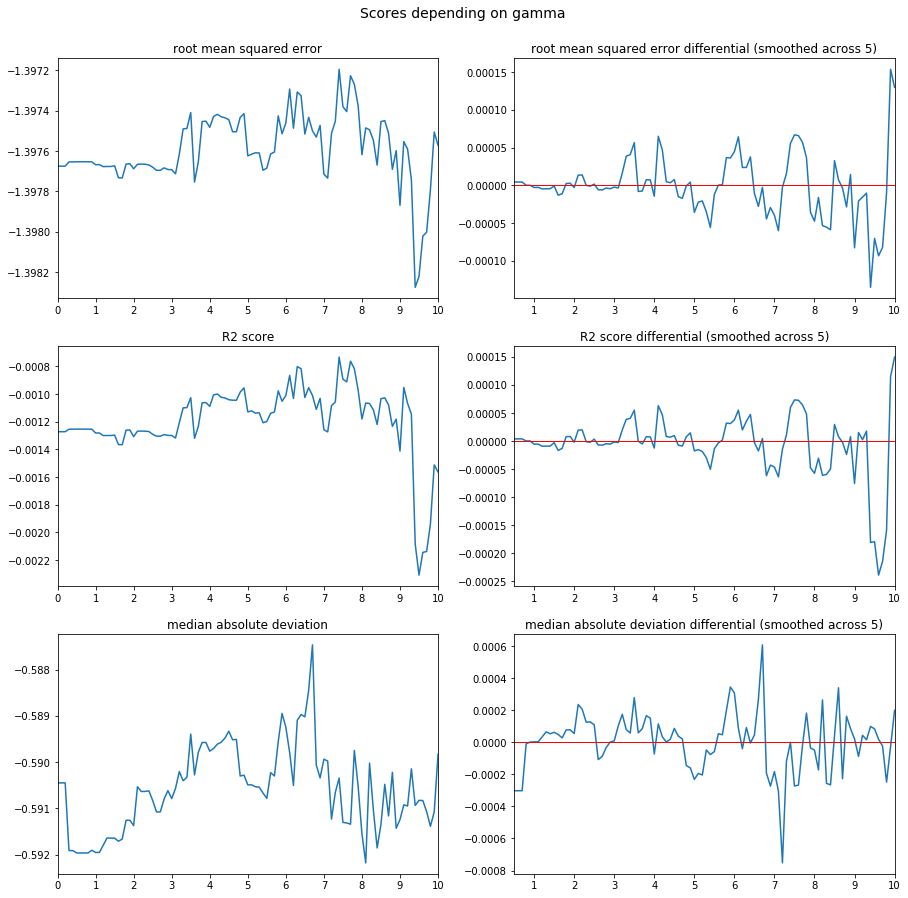

In [6]:
param_grid2 = {
    'learning_rate': [.0044],
    'n_estimators': [680],
    'max_depth': [3],
    'subsample': [.131],
    'colsample_bytree': [0.5],
    'colsample_bynode': [0.8],
    'min_child_weight': [25],
    'gamma': np.linspace(0, 10, 101),
    'reg_lambda': [1.35]
}

grid2 = gridsearch_xgb(X, y, param_grid2, xgb_base_params, save_path='grid2.pkl')
_ = plot_scores_1d(grid2, xtick_step=10)

Grid search with these parameters will take 405 fits, or approximately 39 minutes. Is that ok? (y/N) y
Fitting 5 folds for each of 81 candidates, totalling 405 fits



[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed: 30.5min finished


true elapsed time: 30.6min

best RMSE: -1.3971702174785594
{'colsample_bynode': 0.8, 'colsample_bytree': 0.5, 'gamma': 7.4, 'learning_rate': 0.0044, 'max_depth': 3, 'min_child_weight': 25, 'n_estimators': 680, 'reg_lambda': 1.33, 'subsample': 0.131}

best R2: -0.0006546963422813246
{'colsample_bynode': 0.8, 'colsample_bytree': 0.5, 'gamma': 7.4, 'learning_rate': 0.0044, 'max_depth': 3, 'min_child_weight': 25, 'n_estimators': 680, 'reg_lambda': 1.33, 'subsample': 0.131}

best MAD: -0.5889045970427744
{'colsample_bynode': 0.8, 'colsample_bytree': 0.5, 'gamma': 7.4, 'learning_rate': 0.0044, 'max_depth': 3, 'min_child_weight': 25, 'n_estimators': 680, 'reg_lambda': 1.37, 'subsample': 0.131}


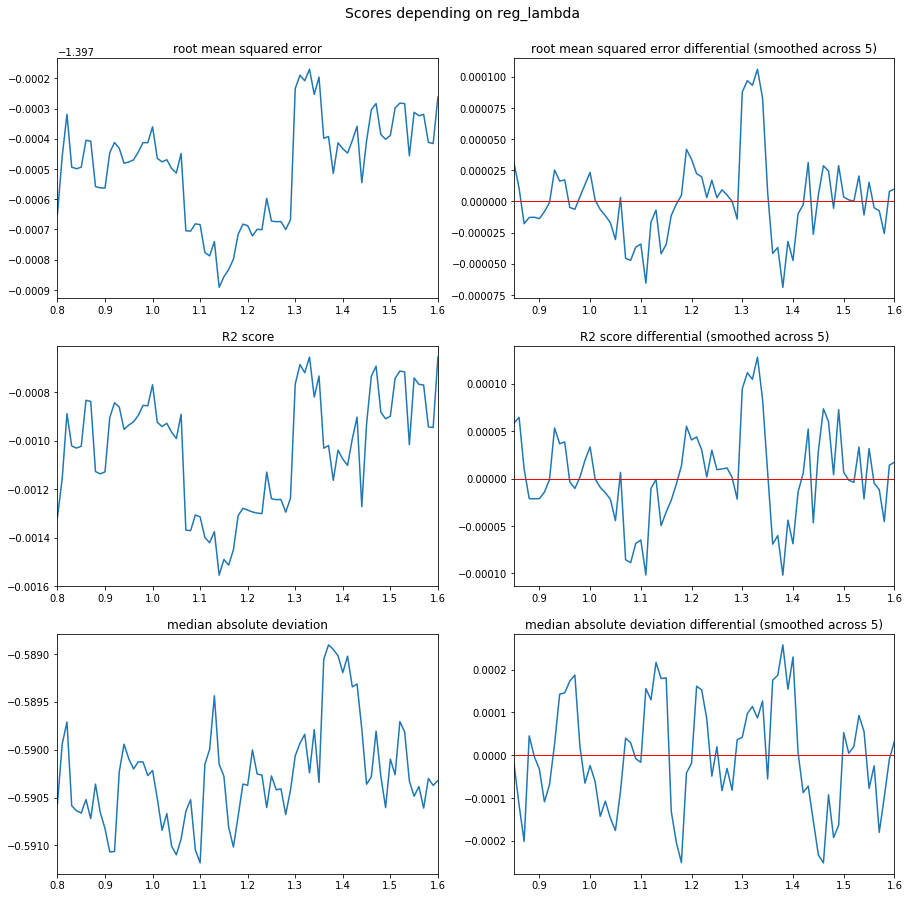

In [8]:
param_grid3 = {
    'learning_rate': [.0044],
    'n_estimators': [680],
    'max_depth': [3],
    'subsample': [.131],
    'colsample_bytree': [0.5],
    'colsample_bynode': [0.8],
    'min_child_weight': [25],
    'gamma': [7.4],
    'reg_lambda': np.linspace(0.8, 1.6, 81)
}

grid3 = gridsearch_xgb(X, y, param_grid3, xgb_base_params, save_path='grid3.pkl')
_ = plot_scores_1d(grid3, xtick_step=10)

Grid search with these parameters will take 55 fits, or approximately 11 minutes. Is that ok? (y/N) y
Fitting 5 folds for each of 11 candidates, totalling 55 fits



[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:  8.4min finished


true elapsed time: 8.6min

best RMSE: -1.3983917734455047
{'colsample_bynode': 0.8, 'colsample_bytree': 0.5, 'gamma': 7.4, 'learning_rate': 0.0022, 'max_depth': 3, 'min_child_weight': 25, 'n_estimators': 1400, 'reg_lambda': 1.33, 'subsample': 0.131}

best R2: -0.002590399168062518
{'colsample_bynode': 0.8, 'colsample_bytree': 0.5, 'gamma': 7.4, 'learning_rate': 0.0022, 'max_depth': 3, 'min_child_weight': 25, 'n_estimators': 1400, 'reg_lambda': 1.33, 'subsample': 0.131}

best MAD: -0.591472747087485
{'colsample_bynode': 0.8, 'colsample_bytree': 0.5, 'gamma': 7.4, 'learning_rate': 0.0022, 'max_depth': 3, 'min_child_weight': 25, 'n_estimators': 1320, 'reg_lambda': 1.33, 'subsample': 0.131}


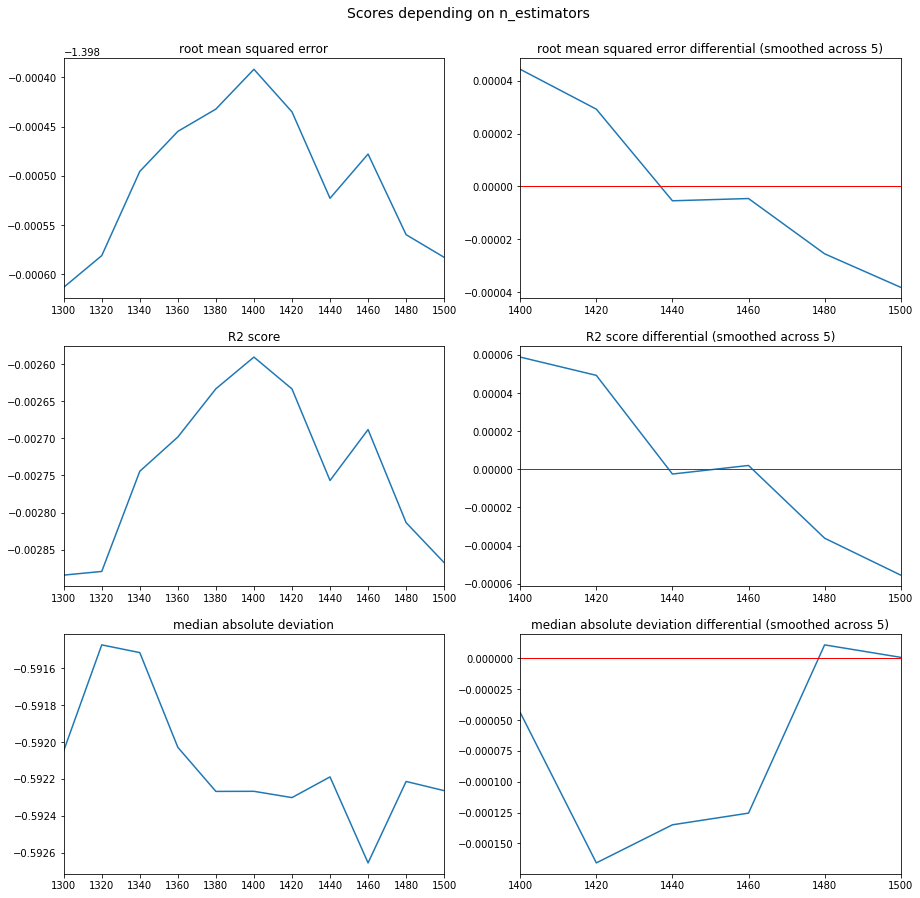

In [9]:
param_grid4 = {
    'learning_rate': [.0022],
    'n_estimators': np.arange(1300, 1501, 20),
    'max_depth': [3],
    'subsample': [.131],
    'colsample_bytree': [0.5],
    'colsample_bynode': [0.8],
    'min_child_weight': [25],
    'gamma': [7.4],
    'reg_lambda': [1.33]
}

grid4 = gridsearch_xgb(X, y, param_grid4, xgb_base_params, save_path='grid4.pkl')
_ = plot_scores_1d(grid4, xtick_step=1)

In [4]:
for metric in ['rmse', 'r2', 'mad']: print_top_n(grid1, 10, metric)

rmse: -1.397445 ± 0.469642
{'colsample_bynode': 0.8, 'colsample_bytree': 0.5, 'gamma': 4.5, 'learning_rate': 0.0044, 'max_depth': 3, 'min_child_weight': 25, 'n_estimators': 680, 'reg_lambda': 1.35, 'subsample': 0.131}

rmse: -1.397470 ± 0.467758
{'colsample_bynode': 0.8, 'colsample_bytree': 0.5, 'gamma': 4.5, 'learning_rate': 0.0044, 'max_depth': 5, 'min_child_weight': 45, 'n_estimators': 680, 'reg_lambda': 1.35, 'subsample': 0.131}

rmse: -1.397701 ± 0.467970
{'colsample_bynode': 0.8, 'colsample_bytree': 0.5, 'gamma': 4.5, 'learning_rate': 0.0044, 'max_depth': 6, 'min_child_weight': 40, 'n_estimators': 680, 'reg_lambda': 1.35, 'subsample': 0.131}

rmse: -1.397778 ± 0.468769
{'colsample_bynode': 0.8, 'colsample_bytree': 0.5, 'gamma': 4.5, 'learning_rate': 0.0044, 'max_depth': 4, 'min_child_weight': 35, 'n_estimators': 680, 'reg_lambda': 1.35, 'subsample': 0.131}

rmse: -1.397794 ± 0.467121
{'colsample_bynode': 0.8, 'colsample_bytree': 0.5, 'gamma': 4.5, 'learning_rate': 0.0044, 'max_de